In [1]:
%matplotlib inline
import numpy as np
import cv2
import matplotlib.pyplot as plt
from datetime import date
from scipy import interpolate

In [2]:
#Function for extracting position and timestamps out of a text file with the extracted
#pose message. The text are generated by running extractMessages on a bag,
def positionExtractor(poseFilename):
    f = open(poseFilename, 'r')
    timestamps, X, Y = [], [], []
    f.readline()
    for line in f:
        l = line.split(',')
        timestamps.append(float(l[0]))
        X.append(float(l[5]))
        Y.append(float(l[6]))
    return X, Y, timestamps

def dist(x1,y1,x2,y2):
    return ((x1-x2)**2+(y1-y2)**2)**(1/2.0)

In [3]:
#Put in the name of the files that contain the track survey data. These should be text files generated from bags
#using the extractMessages.py script. The extractMessages generates text files for many different topics, 
#pose_estimate.txt is the one required here.
innerBoundary = positionExtractor("inner_boundary_survey.txt")
outerBoundary = positionExtractor("outer_boundary_survey.txt")

XinOrig, YinOrig = innerBoundary[0], innerBoundary[1]
XoutOrig, YoutOrig = outerBoundary[0], outerBoundary[1]

In [13]:
#Tune the starting and ending indices so that the there is minimal overlap and 
#no positions from before the survey began.
inStart, inEnd = 100, len(XinOrig) - 1100
outStart, outEnd = 250, len(XoutOrig) - 2250

# plt.plot(XinOrig[inStart:inEnd], YinOrig[inStart:inEnd])
# plt.plot(XoutOrig[outStart:outEnd], YoutOrig[outStart:outEnd])
# plt.show()

In [14]:
#Clip the ends and downsample track survey data
downsamplingFactor = 10
Xin = XinOrig[inStart:inEnd][0::downsamplingFactor]
Yin = YinOrig[inStart:inEnd][0::downsamplingFactor]
Xout = XoutOrig[outStart:outEnd][0::downsamplingFactor]
Yout = YoutOrig[outStart:outEnd][0::downsamplingFactor]

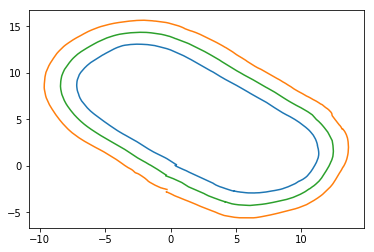

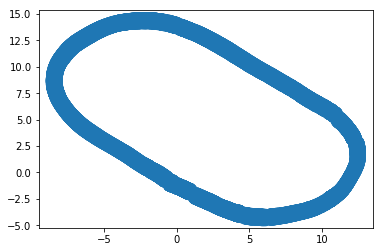

In [15]:
#Compute the centerline based on the left and right track boundaries
Xcen, Ycen, Xw = [], [], []
for ii,(x,y) in enumerate(zip(Xin,Yin)):
    xc, yc = 0.0, 0.0
    currentDistance = np.inf
    for x2,y2 in zip(Xout,Yout):
        distance = dist(x,y,x2,y2)
        if distance < currentDistance:
            currentDistance = distance
            xc = x-((x-x2)/2.0)
            yc = y-((y-y2)/2.0)
    Xcen.append(xc)
    Ycen.append(yc)
    Xw.append(currentDistance)

#Plot the centerline and two boundaries
plt.plot(Xin, Yin)
plt.plot(Xout, Yout)
plt.plot(Xcen,Ycen)
plt.show()

#Plot the width (not to scale, this is just a sanity check)
plt.scatter(Xcen,Ycen,s=np.asarray(Xw)*100)
plt.show()

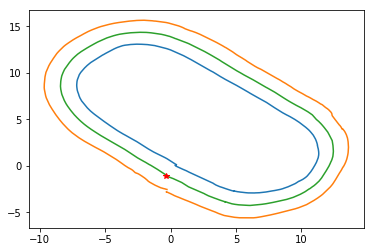

In [16]:
Xstart = Xcen[0]
Ystart = Ycen[0]

#Plot the centerline and two boundaries
plt.plot(Xin, Yin)
plt.plot(Xout, Yout)
plt.plot(Xcen,Ycen)
plt.plot(Xstart, Ystart, 'r*')
plt.show()

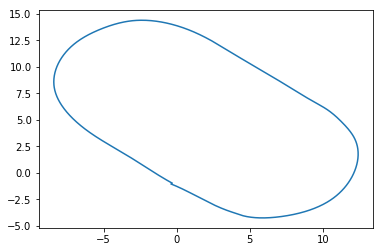

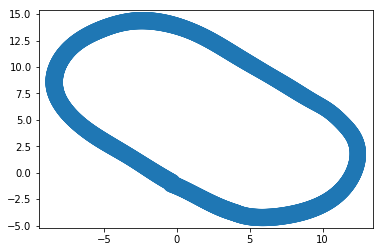

In [42]:
# Spline and interpolate the points to get smooth evenly spaced samples
# assert trackmap is not None

#Get the spline representation
tck, u = interpolate.splprep([Xcen, Ycen], s=1)
wspl,u = interpolate.splprep([Xw], s=1)

#Evaulate spline to get smoother centerline
unew = np.arange(0, 1.001, 0.001)
trackSmooth = interpolate.splev(unew, tck)
wSmooth = interpolate.splev(unew, wspl)

#Plot the results
plt.plot(trackSmooth[0], trackSmooth[1])
plt.show()
plt.scatter(trackSmooth[0], trackSmooth[1],s=wSmooth[0]*100)
plt.show()

In [43]:
#Magic numbers for xBounds, yBounds, and pixelsPerMeter
xBounds = [-13, 17]
yBounds = [-10, 20]
pixelsPerMeter = 20

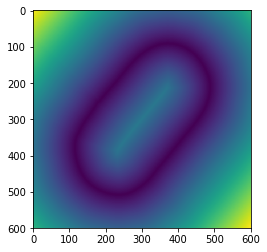

In [44]:
#Create the costmap grid
x = xBounds[0]
y = (yBounds[1] - yBounds[0])/2.0 + yBounds[0]
height = pixelsPerMeter*(xBounds[1] - xBounds[0])
width = pixelsPerMeter*(yBounds[1] - yBounds[0])
map_image = np.zeros((height,width), np.uint8)
map_image.fill(255)

#Transform the track coordinates into pixel coordinates
Ys = trackSmooth[1] - y
Xs = trackSmooth[0] - x
rotated = np.vstack((Xs,Ys))
points = (-pixelsPerMeter*rotated) + np.array([[height],[width/2]])
points = np.fliplr(points.T)

#Compute the signed distance field
cv2.polylines(map_image, np.int32([points]), False, 0, 1)
distimage = cv2.distanceTransform(map_image, cv2.DIST_L2, 5)
sdf = (distimage.astype(np.float) / pixelsPerMeter)
sdf = sdf[::-1,::-1]

#Display the results
plt.imshow(sdf)
plt.show()

In [45]:
#Compute the velocity along the centerline
T = np.linspace(0, 1, len(trackSmooth[0]))
x_vals = trackSmooth[0]
y_vals = trackSmooth[1]
spline_params_x = interpolate.splrep(T, x_vals, k = 3, s=0)
spline_params_y = interpolate.splrep(T, y_vals, k = 3, s=0)
x_vel = interpolate.splev(T, spline_params_x, der = 1)
y_vel = interpolate.splev(T, spline_params_y, der = 1)
curveVelocity = np.sqrt(x_vel**2 + y_vel**2)

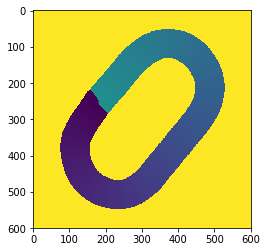

In [46]:
#Now compute the arc length
curve_length = np.zeros(len(trackSmooth[0]))
curve_length[0] = 0
for i in range(1,len(trackSmooth[0])):
    curve_length[i] = curve_length[i-1] + curveVelocity[i]/(1.*len(trackSmooth[0]))

X = np.zeros_like(sdf)
Y = np.zeros_like(sdf)
centerDistProjection = np.zeros_like(sdf)

grid_x = np.linspace(xBounds[0], xBounds[1], (xBounds[1] - xBounds[0])*pixelsPerMeter)
grid_y = np.linspace(yBounds[0], yBounds[1], (yBounds[1] - yBounds[0])*pixelsPerMeter)
for i in range(centerDistProjection.shape[0]):
    for j in range(centerDistProjection.shape[1]):
        if (sdf[i,j] <= 2.0):
            dists = (x_vals - grid_x[i])**2 + (y_vals - grid_y[j])**2
            centerDistProjection[i,j] = curve_length[np.argmin(dists)]
        else:
            centerDistProjection[i,j] = 2.0*np.max(curve_length)
        X[i,j] = grid_x[i]
        Y[i,j] = grid_y[j]

plt.imshow(centerDistProjection)

[ 1.05349551  1.04771383  1.04227439 ...,  1.08521323  1.08413791
  1.08280444]
0.0
21.9595032969


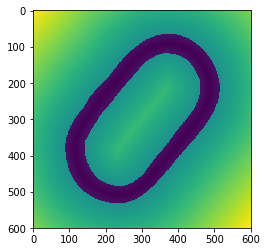

In [47]:
widths = np.copy(wSmooth[0])
track_vals = np.copy(sdf)

x_vals = trackSmooth[0]
y_vals = trackSmooth[1]

X = np.zeros_like(track_vals)
Y = np.zeros_like(track_vals)

grid_x = np.linspace(xBounds[0], xBounds[1], (xBounds[1] - xBounds[0])*pixelsPerMeter)
grid_y = np.linspace(yBounds[0], yBounds[1], (yBounds[1] - yBounds[0])*pixelsPerMeter)

track_vals /= (np.mean(widths)/2.0)
widths /= (np.mean(widths))
max_width = np.max(widths)
print widths

for i in range(grid_x.size):
    for j in range(grid_y.size):
        if track_vals[i,j] >= max_width:
            track_vals[i,j] += 10.0
        else:
            dists = (x_vals - grid_x[i])**2 + (y_vals - grid_y[j])**2
            width = widths[np.argmin(dists)]     
            if (track_vals[i,j] >= width):
                track_vals[i,j] += 10.0
        X[i,j] = grid_x[i]
        Y[i,j] = grid_y[j]

print np.min(track_vals)
print np.max(track_vals)
        
#track_vals = np.clip(track_vals, -10, 10)
channel0 = np.array(track_vals, dtype = np.float32)
channel1 = np.array(centerDistProjection, dtype = np.float32)
channel2 = np.zeros_like(channel0)
channel3 = np.zeros_like(channel0)

#Save data to numpy array, each channel is saved individually as an array in row major order.
track_dict = {
            "X_in":Xin,
            "Y_in":Yin,
            "X_out":Xout,
            "Y_out":Yout,
            "X_cen":Xcen,
            "Y_cen":Ycen,
            "W_cen":Xw,
            "X_cen_smooth":trackSmooth[0],
            "Y_cen_smooth":trackSmooth[1],
            "W_cen_smooth":wSmooth[0],
            "xBounds":np.array([xBounds[0], xBounds[1]], dtype = np.float32), 
            "yBounds":np.array([yBounds[0], yBounds[1]], dtype = np.float32),
            "pixelsPerMeter":np.array([pixelsPerMeter], dtype=np.float32),
            "channel0":channel0.T.flatten(),
            "channel1":channel1.T.flatten(),
            "channel2":channel2.T.flatten(),
            "channel3":channel3.T.flatten(),
            "filterChannel":track_vals.clip(0.0, 1.0).T.flatten()}

trackName = "Marietta"
saveAs = trackName + "_" + str(date.today())

np.savez(saveAs, **track_dict)

#Plot the costmap
plt.imshow(track_vals)